In [1]:
!pip install rouge_score -q

# Import library

In [2]:
import pandas as pd
import numpy as np
import random
import torch
import os
import re

from functools import partial
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from transformers import EncoderDecoderModel, AutoModelForSeq2SeqLM
from transformers import AutoTokenizer

from datasets import Dataset
from torch.utils.data import DataLoader
from datasets import load_dataset, load_metric

# Set reproducibility

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed()

# Dowonload Dataset and Metric

In [4]:
raw_datasets = load_dataset("xsum")
metric = load_metric("rouge")
raw_datasets

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

# Select randomly half train set

In [5]:
# Generate index
# train_len = len(raw_datasets['train'])
# indexes = random.sample(range(train_len), train_len // 2)

# file = open('./indexes.txt','w')
# for index in indexes:
#     file.write(str(index) + "\n")
# file.close()

# Use indexes generated
with open("/kaggle/input/indexes/indexes.txt", "r") as file:
    indexes = [int(line.strip()) for line in file]

In [6]:
raw_datasets['train'] = raw_datasets['train'].select(indexes)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 102022
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

# Have a quick look on the data

In [7]:
df = pd.concat([pd.DataFrame(raw_datasets['train']), pd.DataFrame(raw_datasets['validation'])]).reset_index()

Longest sentence has 29059 words.
mean sentence length is 357.68 words.
std = 295.01.
Lenghts of sentences longer than 512 words: 24439



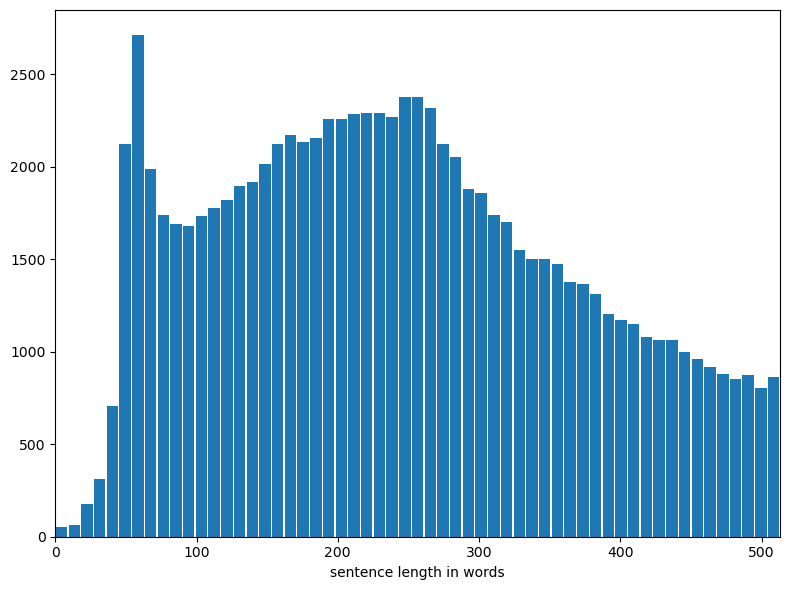

In [8]:
sentence_lengths = np.array([len(text.split(' ')) for text in df['document']])

print(f"Longest sentence has {np.max(sentence_lengths)} words.")
print(f"mean sentence length is {np.mean(sentence_lengths):.2f} words.")
print(f"std = {np.std(sentence_lengths):.2f}.")

m = 512
print(f"Lenghts of sentences longer than {m} words: {len(sentence_lengths[np.where(sentence_lengths>m)])}")
print()

w, h, dpi = 800, 600, 100
fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)

#ax.hist(np.where(sentence_lengths<=m, sentence_lengths, m), bins=np.arange(m+2, step=20), rwidth=0.9)
ax.hist(sentence_lengths.clip(max=m+2), bins=np.arange(m+2, step=9), rwidth=0.9)
ax.set_xlabel('sentence length in words')
ax.set_xlim(0, m+1)

fig.tight_layout()
fig.savefig('document_lengths.pdf')
plt.show()

Longest sentence has 86 words.
mean sentence length is 21.10 words.
std = 5.23.
Lenghts of sentences longer than 50 words: 58



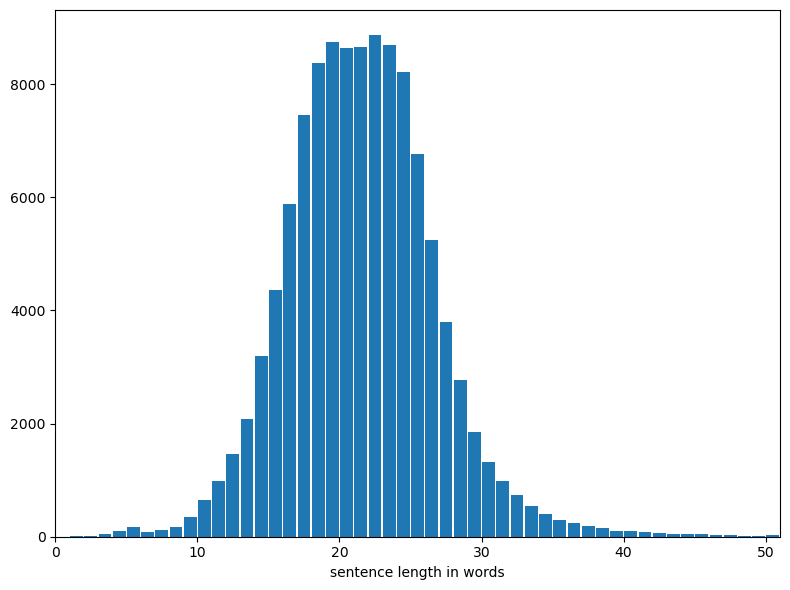

In [9]:
sentence_lengths = np.array([len(text.split(' ')) for text in df['summary']])

print(f"Longest sentence has {np.max(sentence_lengths)} words.")
print(f"mean sentence length is {np.mean(sentence_lengths):.2f} words.")
print(f"std = {np.std(sentence_lengths):.2f}.")

m = 50
print(f"Lenghts of sentences longer than {m} words: {len(sentence_lengths[np.where(sentence_lengths>m)])}")
print()

w, h, dpi = 800, 600, 100
fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)

ax.hist(sentence_lengths.clip(max=m+2), bins=np.arange(m+2), rwidth=0.9)
ax.set_xlabel('sentence length in words')
ax.set_xlim(0, m+1)

fig.tight_layout()
fig.savefig('summary_lengths.pdf')
plt.show()

# Define Model

In [10]:
# model_checkpoint = "prajjwal1/bert-tiny"
model_checkpoint = "distilroberta-base"
# model_checkpoint = "t5-small"
# model_checkpoint = "mk9165/mk-bart-small-v5"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

if model_checkpoint  in ['mk9165/mk-bart-small-v5', 't5-small']:
    #Seq2Seq MOdel
    s2s_model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

if model_checkpoint  in ['prajjwal1/bert-tiny', 'distilroberta-base']:
    #Seq2Seq MOdel
    s2s_model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_checkpoint, model_checkpoint)
    s2s_model.config.decoder.is_decoder = True
    s2s_model.config.decoder.add_cross_attention = True
    s2s_model.config.decoder_start_token_id = tokenizer.cls_token_id
    s2s_model.config.pad_token_id = tokenizer.pad_token_id
    s2s_model.config.vocab_size = s2s_model.config.encoder.vocab_size

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.3.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.3.crossatt

# Preprocessing

In [11]:
# Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
                
        row=re.sub("(\\t)", ' ', str(row)) #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)) 
        row=re.sub("(\\n)", ' ', str(row))
        
        row=re.sub("(__+)", ' ', str(row))   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row))   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row))   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row))   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row))   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)) #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)) #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)) #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)) #replace INC nums to INC_NUM
        row=re.sub("([mM]cC][\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)) #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)) #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)) #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)) #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)) #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        
        row = re.sub("(\s+)",' ',str(row)) #remove multiple spaces
        
        #Should always be last
        #row=re.sub("(\s+.\s+)", ' ', str(row)) #remove any single charecters hanging between 2 spaces        
        
        yield row.lower()

# Tokenization

In [12]:
def prepare_train_features_bert(examples, tokenizer, encoder_max_length=512, decoder_max_length=64, prefix=None):

    # tokenize the document
    inputs = list(text_strip(examples["document"]))
    tokenized_inputs = tokenizer(inputs, truncation=True, max_length=encoder_max_length, padding="max_length")

    # tokenize the summary
    outputs = list(text_strip(examples["summary"]))
    tokenized_outputs = tokenizer(outputs, truncation=True, max_length=decoder_max_length, padding="max_length")

    examples["input_ids"] = tokenized_inputs.input_ids
    examples["attention_mask"] = tokenized_inputs.attention_mask
    examples["decoder_input_ids"] = tokenized_outputs.input_ids
    examples["decoder_attention_mask"] = tokenized_outputs.attention_mask
    examples["labels"] = tokenized_outputs.input_ids.copy()

    examples["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in examples["labels"]]

    return examples

def prepare_train_features_bart(examples, tokenizer, encoder_max_length=512, decoder_max_length=64, prefix=""):
    # tokenize the document
    # inputs = list(text_strip(examples["document"]))
    inputs = [prefix + doc for doc in text_strip(examples["document"])]
    model_inputs = tokenizer(inputs, truncation=True, max_length=encoder_max_length, padding="max_length")

    # tokenize the summary
    outputs = list(text_strip(examples["summary"]))
    labels = tokenizer(outputs, truncation=True, max_length=decoder_max_length, padding="max_length")

    model_inputs["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels["input_ids"]]

    return model_inputs

# Metric

In [13]:
def compute_metrics(tokenizer, labels_ids, pred_ids):
    """Training metrics for sequence-to-sequence encoder-decoder.
    The tokenizer must be fixed, e.g. using ``functools.partial``."""

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    
    return metric.compute(predictions=pred_str, references=label_str)

# Define training loop

In [14]:
def s2s_trainer(
    model_checkpoint,
    model,
    train_dataset,
    val_dataset,
    tokenizer,
    encoder_max_length=512,
    decoder_max_length=64,
    epochs=3,
    batch_size=32,
    learning_rate=5e-5,
    prefix = ""
):
    if model_checkpoint  in ['mk9165/mk-bart-small-v5', 't5-small']:
        prepare_train_features = prepare_train_features_bart
        if model_checkpoint == 't5-small':
            prefix = "summarize: "
        
    if model_checkpoint  in ['prajjwal1/bert-tiny', 'distilroberta-base']:
        prepare_train_features = prepare_train_features_bert
        
    
    column_names = train_dataset.column_names

    print('--------------START TOKENIZETION--------------')
    train_dataset = train_dataset.map(
        partial(prepare_train_features,
                tokenizer=tokenizer,
                encoder_max_length=encoder_max_length,
                decoder_max_length=decoder_max_length,
                prefix=prefix),
        batched=True,
        remove_columns=column_names,
        num_proc=3,
    )
    print('--------------TRAIN DATA TOKENIZED--------------')
    
    train_dataset.set_format(type="torch")

    val_dataset = val_dataset.map(
        partial(prepare_train_features,
                tokenizer=tokenizer,
                encoder_max_length=encoder_max_length,
                decoder_max_length=decoder_max_length,
                prefix=prefix),
        batched=True,
        remove_columns=column_names,
        num_proc=3,
    )
    print('--------------VAL DATA TOKENIZED--------------')

    val_dataset.set_format(type="torch")

    ## Load with a DataLoader...
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    model.to('cuda')

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print('--------------START TRAINING ENCODER DECODER--------------')
    for epoch in range(1, epochs+1):

        # Train
        model.train()

        train_loss = 0 # cumulative loss

        loop = tqdm(train_loader)
        for batch in loop:
            input_ids = batch["input_ids"].to('cuda')
            attention_mask = batch["attention_mask"].to('cuda')
            labels = batch["labels"].to('cuda')
            # Forward Pass
            output = model(input_ids=input_ids, 
                            attention_mask=attention_mask, 
                             labels=labels)
            # Find the Loss
            loss = output.loss
            # Clear the gradients
            optimizer.zero_grad()
            # Calculate gradients 
            loss.backward()
            # Update Weights
            optimizer.step()
            # Calculate Loss
            train_loss += loss.item()

            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=loss.item())

        # Compute average loss per epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validate
        model.eval()
        valid_loss = 0 
        rouge1_f1 = 0
        rouge2_f1 = 0
        rougeL_f1 = 0
        rougeLsum_f1 = 0
        loop = tqdm(val_loader)
        with torch.no_grad():
            for batch in loop:
                input_ids = batch["input_ids"].to('cuda')
                attention_mask = batch["attention_mask"].to('cuda')
                labels = batch["labels"].to('cuda')
                # Forward Pass
                output = model(input_ids=input_ids, 
                             attention_mask=attention_mask, 
                             labels=labels)
                # Make predictions
                pred_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask)

                # Find the Loss
                loss = output.loss
                # Calculate Loss
                valid_loss += loss.item()
                # Metric: compute f1-score
                batch_rouge1_f1 = compute_metrics(tokenizer, labels, pred_ids)['rouge1'][1][2]
                rouge1_f1 += batch_rouge1_f1

                batch_rouge2_f1 = compute_metrics(tokenizer, labels, pred_ids)['rouge2'][1][2]
                rouge2_f1 += batch_rouge2_f1

                batch_rougeL_f1 = compute_metrics(tokenizer, labels, pred_ids)['rougeL'][1][2]
                rougeL_f1 += batch_rougeL_f1

                batch_rougeLsum_f1 = compute_metrics(tokenizer, labels, pred_ids)['rougeLsum'][1][2]
                rougeLsum_f1 += batch_rougeLsum_f1

                loop.set_description(f'Valid {epoch}')
                loop.set_postfix(loss=loss.item(), rouge1_f1=batch_rouge1_f1, rouge2_f1=batch_rouge1_f1, rougeL_f1=batch_rouge1_f1, rougeLsum_f1=batch_rouge1_f1)

            avg_val_loss = valid_loss / len(val_loader)
            avg_rouge1_f1_score = rouge1_f1 / len(val_loader)
            avg_rouge2_f1_score = rouge2_f1 / len(val_loader)
            avg_rougeL_f1_score = rougeL_f1 / len(val_loader)
            avg_rougeLsum_f1_score = rougeLsum_f1 / len(val_loader)

        print(f'Epoch {epoch}:\t train-loss = {avg_train_loss:.2f}\t val-loss = {avg_val_loss:.2f}\t val-rouge1-f1 = {avg_rouge1_f1_score:.3f} \t val-rouge2-f1 = {avg_rouge2_f1_score:.3f} \t val-rougeL-f1 = {avg_rougeL_f1_score:.3f} \t val-rougeLsum-f1 = {avg_rougeLsum_f1_score:.3f} ')

    print('--------------END TRAINING ENCODER DECODER--------------')

# Training

In [15]:
s2s_trainer(model_checkpoint,
            model=s2s_model,
            train_dataset=raw_datasets['train'],
            val_dataset=raw_datasets['validation'],
            tokenizer=tokenizer,
            encoder_max_length=512,
            decoder_max_length=32,
            batch_size=16,)

--------------START TOKENIZETION--------------
    

#0:   0%|          | 0/35 [00:00<?, ?ba/s]

#2:   0%|          | 0/35 [00:00<?, ?ba/s]

#1:   0%|          | 0/35 [00:00<?, ?ba/s]

--------------TRAIN DATA TOKENIZED--------------
    

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#2:   0%|          | 0/4 [00:00<?, ?ba/s]

--------------VAL DATA TOKENIZED--------------
--------------START TRAINING ENCODER DECODER--------------


  0%|          | 0/6377 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
  0%|          | 0/709 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1187: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_gener

Epoch 1:	 train-loss = 3.73	 val-loss = 3.01	 val-rouge1-f1 = 0.202 	 val-rouge2-f1 = 0.039 	 val-rougeL-f1 = 0.165 	 val-rougeLsum-f1 = 0.165 


Valid 2: 100%|██████████| 709/709 [17:51<00:00,  1.51s/it, loss=2.26, rouge1_f1=0.252, rouge2_f1=0.252, rougeL_f1=0.252, rougeLsum_f1=0.252]


Epoch 2:	 train-loss = 2.76	 val-loss = 2.63	 val-rouge1-f1 = 0.258 	 val-rouge2-f1 = 0.072 	 val-rougeL-f1 = 0.211 	 val-rougeLsum-f1 = 0.211 


Valid 3: 100%|██████████| 709/709 [18:18<00:00,  1.55s/it, loss=2.02, rouge1_f1=0.362, rouge2_f1=0.362, rougeL_f1=0.362, rougeLsum_f1=0.362]

Epoch 3:	 train-loss = 2.43	 val-loss = 2.50	 val-rouge1-f1 = 0.280 	 val-rouge2-f1 = 0.088 	 val-rougeL-f1 = 0.230 	 val-rougeLsum-f1 = 0.230 
--------------END TRAINING ENCODER DECODER--------------


# Prediction

In [16]:
def generate(batch, tokenizer, model, max_length=512):

    inputs = tokenizer(list(text_strip(batch["document"])), 
                       padding="max_length",
                       truncation=True,
                       max_length=max_length,
                       return_tensors="pt")

    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")
    
    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens includsing will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str
    # return output_str
    return batch

In [17]:
print('--------------START GENERATION ANSWERS--------------')

results = raw_datasets['test'].map(partial(generate, tokenizer=tokenizer,model=s2s_model), 
                                   batched=True, 
                                   batch_size=16,)

results.to_csv('./distil-roberta.csv', index=False)

--------------START GENERATION ANSWERS--------------


  0%|          | 0/709 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

27742601